## Basic Relative Permeability Example in 2D
This example using invasion percolation to invade air (non-wetting) into a water-filled (wetting) 2D network.  Being in 2D helps with visualization of the results

In [1]:
import warnings
import scipy as sp
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.random.seed(10)
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 40

### Initialize Required Objects
We'll use several pre-defined classes here to simplify the example, allowing us to focus on the actual problem of computing relative permeability.

In [2]:
pn = op.network.Cubic(shape=[100, 100, 1])
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
phys = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)

### Using InvasionPercolation to Simulate Air Invasion
The InvasionPercolation algorithm will be used to simulaton the air invasion.  We'll inject only from one face ('back'), and will otherwise use all the default behavior, such as no trapping.  

In [3]:
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=air)
ip.set_inlets(pores=pn.pores(['back']))
ip.run()

The ``plot_coordinates`` function in ``openpnm.topotools`` can be used to create a quick and simple plot of the invasion pattern.  Note that the ``ip`` object possesses a method called ``results``, which accepts as an argument the desired saturation.  By passing in ``Snwp=0.1`` this method returns a dictionary containing boolean arrays under the keys 'pore.occupancy' and 'throat.occupancy'.  By catching this dictionary with the phase object (``air.update``) the phase now has arrays ``'pore.occupancy'`` and ``'throat.occupancy'``.  In the following lines, we visualize the invasion pattern by plotting only those pore that have been filled by invading air.

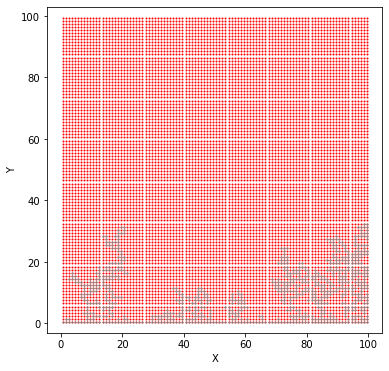

In [4]:
# NBVAL_IGNORE_OUTPUT
air.update(ip.results(Snwp=0.1))
fig = plt.figure(figsize=(6, 6))
fig = op.topotools.plot_coordinates(network=pn, fig=fig)
fig = op.topotools.plot_coordinates(network=pn, fig=fig, pores=air['pore.occupancy'], color='grey')

### Create StokesFlow Algorithm
Now that the invasion pattern for this domain has been established using IP, we can start to see what effect the presence of each phase has on the effective permeability of the other.

In [5]:
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
st.set_value_BC(pores=pn.pores('left'), values=1)
st.set_value_BC(pores=pn.pores('right'), values=0)

We can solve the flow problem on the netowrk without altering the throat conductances, which will give us the maximum flow through the domain for single phase flow:

In [6]:
st.run()
Qmax = st.rate(pores=pn.pores('left'))
print(Qmax)

[0.0453]


Next we will illustrate how to alter the hydraulic conductances of the water phase to account for the presence of air filled pores and throats.  Start by passing 'pore.occupancy' and 'throat.occupancy' to the air object at a specified saturation (0.1 in this case), then reach into the ``phys2`` object and set the conductance of the air filled throats to 1000x lower than the least conductive water filled throat

In [7]:
air.update(ip.results(Snwp=0.1))
val = np.amin(phys_water['throat.hydraulic_conductance'])/1000
phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val

We then re-run the flow problem, which will now utilize the altered hydraulic conductance values.  The pressure field calculated by the StokesFlow algorithm (``st``) must be passed back to the Phase object (``water``).

In [8]:
st.run()
water.update(st.results())

Finally we can visualize the pressure field quickly using OpenPNM's build in ``plot_coordinates`` function.  Note that we set all pores that are invaded with air to have a 0 pressure by multiplying the result by the inverse of the ``air['pore.occupancy']` array`, which sets the invaded pores to a dark color.

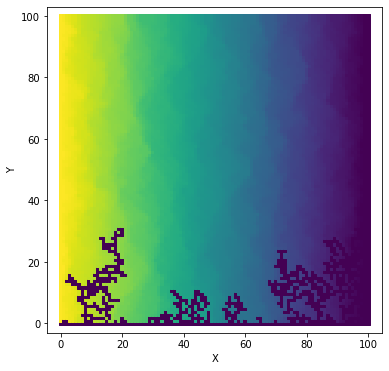

In [9]:
# NBVAL_IGNORE_OUTPUT
fig = plt.figure(figsize=(6, 6))
fig = op.topotools.plot_coordinates(network=pn, c=water['pore.pressure']*~air['pore.occupancy'], fig=fig,
                                    s=50, marker='s')

### Calculate Relative Permeability Curve
The above illustration showed how to get the effective permeability at one saturation.  We now put this logic into a for loop to obtain water flow rates throat the partialy air-invaded network at a variety of saturations.  

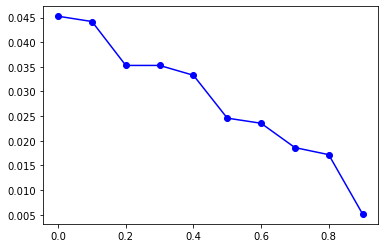

In [10]:
# NBVAL_IGNORE_OUTPUT
phys_water.regenerate_models()  # Regenerate phys2 to reset any calculation done above
data = []  # Initialize a list to hold data
for s in np.arange(0, 1, 0.1):  # Loop through saturations
    # 1: Update air object with occupancy at given saturation
    air.update(ip.results(Snwp=s))
    # 2: Overwrite water's hydraulic conductance in air-filled locations
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val
    # 3: Re-run flow problem
    st.run()
    # 4: Compute flow through inlet phase and append to data
    data.append([s, st.rate(pores=pn.pores('left'))[0]])
data = np.vstack(data).T  # Convert data to numpy array
# Plot relative permeability curve for water flow in partially air filled network
plt.plot(*data, 'b-o')
plt.show()